## Reading and visualizing the data

In the search for a solution ot keep all 50 million images in memory i evaluated:
- generating and compressing grasycale images 
- compressing the drawing



Both methods works: 
- Webp compression for grayscale images is very efficient with a fast decompression. The compression takes about 5h 30 min 
- Brotli compression of strokes in text format is as efficient as bz2 decompresses. Both compress much better than zlib. Brotli and zlib's decompression is 3 times fast compared to bz2. The compression takes about 10h 30 min (very slow compared to bz2 and zlib). 
- i have a macbook pro mid 2016

Decompression of 50 million images can be generated form the compressed state to images in 13 and 26 min from the compressed drawing and compressed images respectively


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from code import *
from graphics import *

import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import gc
from pickle import *

from core_ai.lib.data import *


In [3]:
input_data       = Path("/Users/kasparlund/DropBox")
data             = Path("../data/google_quick_draw")

stroke_dir       = input_data/"train_simplified"
one_stroke_file  = stroke_dir/"ambulance.csv"

data_prepared    = data/"train"
data_prepared.mkdir(exist_ok=True)
data_compressed  = data/"compressed"
data_compressed.mkdir(exist_ok=True)

#astrokes_file = data_prepared/"train_simplified.csv"
vocab_file      = data_compressed/"vocab.json"

train_ds_file = data_prepared/"train_dataset.pkl"
valid_ds_file = data_prepared/"valid_dataset.pkl"

In [4]:
size, line_width  = 28, 1
valid_ratio = 0.1
linetype    = cv2.LINE_8 #cv2.LINE_AA
compressed_drawings = True

"""
images_file      = data_prepared/f"imgs_webp_{size}x{size}_lw{line_width}.pkl"
drawings_file    = data_prepared/f"c_drawings.pkl"
train_valid_name = "c_drawing_train_valid" if compressed_drawings else \
                    f"c_image_train_valid_{size}x{size}_lw{line_width}.gzip"
train_valid_file = data_prepared/f"{train_valid_name}.gzip"
"""


In [5]:
print(data_compressed.exists()), print(data.exists()), print(one_stroke_file.exists())
images_file,train_valid_file

True
True
True


(PosixPath('../data/google_quick_draw/train/imgs_webp_28x28_lw1.pkl'),
 PosixPath('../data/google_quick_draw/train/c_drawing_train_valid.gzip'))

## analyses one data tabel

## Prepare data

- compress all images or drawings into lists of compressed drawing or images, 
- create one annotation file
- replace space in labels with _
- create vocabulary file to tranlate between label and numeric tokens

- create a traiing and validation dataframe with the minimum number of required columns from the annotation file and the compressed image or drawing 

In [6]:
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

import pickle
def merge_stroke_files(stroke_dir:Path, vocab_file:Path, compressed_file:Path, compressed_drawings:bool ):
    nrows = 0
    vocab = {}
    token = 0
    files = list( stroke_dir.glob("*.csv") )
    for f in  progress_bar(files):
        gc.collect()
        print(f"processing: {f.name}")
        df = pd.read_csv(f)
        #df.drop(["timestamp"], axis=1, inplace=True)
                
        #replace space in label with _, add label to vocab and create word_code column
        if sum(pd.isna(df['word'])) > 0: print(f"nan in word field for file:{f}")
        df["word"] = df["word"].apply( lambda word: word.strip().replace(" ", "_") )
        vocab[df["word"][0]] = token
        df["word_code"]      = token
        df["word_code"] = df["word_code"].astype(np.uint16)
        token += 1
                
        if compressed_drawings:
            df["drawing"] = [brotli.compress(txt.encode("utf-8"), quality=11) for txt in df["drawing"] ]
        else:    
            df["drawing"] = convert_strokes2webp(df["drawing"], size, line_width)
            
        #include header at first write
                  
        f_out = (data_compressed/f.name).with_suffix(".gzip")
        df.to_pickle(f_out, protocol=pickle.HIGHEST_PROTOCOL) 
                  
        #with (data_compressed/f.name).open("w") as fc: df.to_csv(fc, encoding="utf-8")                 
        nrows += df.shape[0]
        df = None
                                           
    with open(vocab_file, 'w') as fp:
        json.dump(vocab, fp)
                                           
    print(f"total number of records: {nrows}") 
    print(f"vocab size:{len(vocab)}:\n{vocab}")
    gc.collect()

if not vocab_file.exists():
    if compressed_drawings: 
        %time merge_stroke_files(stroke_dir, vocab_file, drawings_file, compressed_drawings=compressed_drawings)
    else:
        %time merge_stroke_files(stroke_dir, vocab_file, images_file,   compressed_drawings=False)        
        

In [7]:
def read_and_split( file, columns:list,  valid_ratio:float):
    #df = pd.read_csv(f, encoding="utf-8", usecols=columns, dtype=dtype_columns)        
    df = pd.read_pickle(file)
    
    if columns is not None:
        drop_cols = [c for c in df.columns if not c in columns]
        df.drop(labels=drop_cols, axis="columns", inplace=True)
        
    ix_valid    = np.random.randint(0, len(df), size=int(len(df)*valid_ratio+.5) )
    df["train"] = True
    df.iloc[ix_valid, df.columns.get_loc("train")] = False
    
    return df

def read_and_split_all( compressed_dir:Path, columns:list=None, valid_ratio:float = valid_ratio ):
    total_rows = 0
    ext        = "*.gzip" #"*.csv"
    files      = list( compressed_dir.glob(ext) )
    #files     = list( compressed_dir.glob(ext) )[:1]
    for f in  progress_bar(files):
        print(f"processing: {f.name}")
        df = read_and_split( f, columns,  valid_ratio)
        yield df
                
        total_rows += df.shape[0]
    return df   

def draw_images_from_df(df, nb=1000, nrows=8, compressed_drawings=True):
    compressed = [df.drawing.iloc[i] for i in np.random.randint(0,len(df),nb) ]
    if compressed_drawings:
        print("reading and converting compressed drawings to images")
        ims = drawings2images(compressed, size, line_width, linetype, compressed_drawings) 
    else:    
        print("reading and decompressing images")
        ims = decode_images( compressed )
    
    print(f"plot images : {len(ims)}")
    plot_images( ims, cm.Greys, max_rows_cols=nrows )

In [8]:
%%time
from core_ai.lib.data import *
#create a training file with numericalized words and training vs validation samples
def createDatasets():
    
    #move the vocab file to data_prepared
    with vocab_file.open('r') as fp:
        vocab = json.load(fp)        
        with (data_prepared/vocab_file.name).open('w') as fp:
            json.dump(vocab, fp)
            
    #read all to get the toal lenght        
    dfs=[]
    n_rows=0
    for df in read_and_split_all(data_compressed, columns=["word_code","drawing"], valid_ratio=valid_ratio):
        gc.collect()
        dfs.append(df)
        n_rows += len(df)
    
    #create datasets consisting of nd.arrays and fill them in
    gc.collect()
    train_ds = GDDataset( np.empty(n_rows,dtype=np.object), np.empty(n_rows,dtype=np.uint16))
    is_train = np.empty(n_rows,np.bool)
    
    n_rows = 0
    for df in dfs:
        train_ds.x[n_rows:n_rows+len(df)] = df.drawing.values[:]
        train_ds.y[n_rows:n_rows+len(df)] = df.word_code.values[:]
        is_train[n_rows:n_rows+len(df)]   = df.train.values[:]
        df.drop(labels=["train"], axis=1, inplace=True)
        n_rows += len(df)
    dfs = None
    gc.collect()
    
    
    valid_ds = GDDataset( train_ds.x[is_train==False], train_ds.y[is_train==False] )
    with valid_ds_file.open("wb") as f:
        %time pickle.dump(valid_ds, f, pickle.HIGHEST_PROTOCOL)
        valid_ds = None
        gc.collect()  
        
    train_ds.x = train_ds.x[is_train]
    train_ds.y = train_ds.y[is_train]
    is_train = None
    gc.collect()

    with train_ds_file.open("wb") as f:
        %time pickle.dump(train_ds, f, pickle.HIGHEST_PROTOCOL)
        train_ds=None
        gc.collect()  

createDatasets()

processing: blueberry.gzip-------| 0.00% [0/340 00:00<00:00]
processing: rabbit.gzip----------| 0.29% [1/340 00:00<00:51]
processing: firetruck.gzip-------| 0.59% [2/340 00:00<00:49]
processing: smiley face.gzip-----| 0.88% [3/340 00:00<00:51]
processing: horse.gzip-----------| 1.18% [4/340 00:00<00:50]
processing: axe.gzip-------------| 1.47% [5/340 00:00<00:51]
processing: dishwasher.gzip------| 1.76% [6/340 00:00<00:48]
processing: bear.gzip------------| 2.06% [7/340 00:00<00:47]
processing: violin.gzip----------| 2.35% [8/340 00:01<00:46]
processing: drums.gzip-----------| 2.65% [9/340 00:01<00:47]
processing: tree.gzip------------| 2.94% [10/340 00:01<00:46]
processing: soccer ball.gzip-----| 3.24% [11/340 00:01<00:46]
processing: toaster.gzip---------| 3.53% [12/340 00:01<00:46]
processing: vase.gzip------------| 3.82% [13/340 00:01<00:45]
processing: pencil.gzip----------| 4.12% [14/340 00:01<00:44]
processing: bicycle.gzip---------| 4.41% [15/340 00:02<00:43]
processing: mouse.

processing: teddy-bear.gzip------| 38.82% [132/340 00:17<00:28]
processing: lightning.gzip-------| 39.12% [133/340 00:18<00:28]
processing: string bean.gzip-----| 39.41% [134/340 00:18<00:27]
processing: hand.gzip------------| 39.71% [135/340 00:18<00:27]
processing: triangle.gzip--------| 40.00% [136/340 00:18<00:27]
processing: headphones.gzip------| 40.29% [137/340 00:18<00:27]
processing: microphone.gzip------| 40.59% [138/340 00:18<00:27]
processing: sink.gzip------------| 40.88% [139/340 00:18<00:27]
processing: moustache.gzip-------| 41.18% [140/340 00:19<00:27]
processing: roller coaster.gzip--| 41.47% [141/340 00:19<00:27]
processing: wine glass.gzip------| 41.76% [142/340 00:19<00:26]
processing: telephone.gzip-------| 42.06% [143/340 00:19<00:26]
processing: postcard.gzip--------| 42.35% [144/340 00:19<00:26]
processing: underwear.gzip-------| 42.65% [145/340 00:19<00:26]
processing: paper clip.gzip------| 42.94% [146/340 00:19<00:26]
processing: mug.gzip-------------| 43.24

processing: skateboard.gzip------| 76.76% [261/340 00:38<00:11]
processing: house.gzip███--------| 77.06% [262/340 00:38<00:11]
processing: asparagus.gzip-------| 77.35% [263/340 00:38<00:11]
processing: rhinoceros.gzip------| 77.65% [264/340 00:38<00:11]
processing: ocean.gzip████-------| 77.94% [265/340 00:39<00:11]
processing: passport.gzip█-------| 78.24% [266/340 00:39<00:10]
processing: eraser.gzip███-------| 78.53% [267/340 00:39<00:10]
processing: goatee.gzip███-------| 78.82% [268/340 00:39<00:10]
processing: swing set.gzip-------| 79.12% [269/340 00:39<00:10]
processing: rainbow.gzip██-------| 79.41% [270/340 00:40<00:10]
processing: penguin.gzip██-------| 79.71% [271/340 00:40<00:10]
processing: sea turtle.gzip------| 80.00% [272/340 00:40<00:10]
processing: speedboat.gzip-------| 80.29% [273/340 00:40<00:09]
processing: duck.gzip█████-------| 80.59% [274/340 00:40<00:09]
processing: panda.gzip█████------| 80.88% [275/340 00:40<00:09]
processing: cookie.gzip████------| 81.18

# in the training phase we would read data as shown below

In [9]:
%%time
train_ds, valid_ds = readDatasets(train_ds_file, valid_ds_file)


CPU times: user 13.8 s, sys: 24.3 s, total: 38.1 s
Wall time: 49.4 s


training dataset  : (44977310, 44977310)
validation dataset: (4730269, 4730269)
reading and converting compressed drawings to images
plot images : 1000


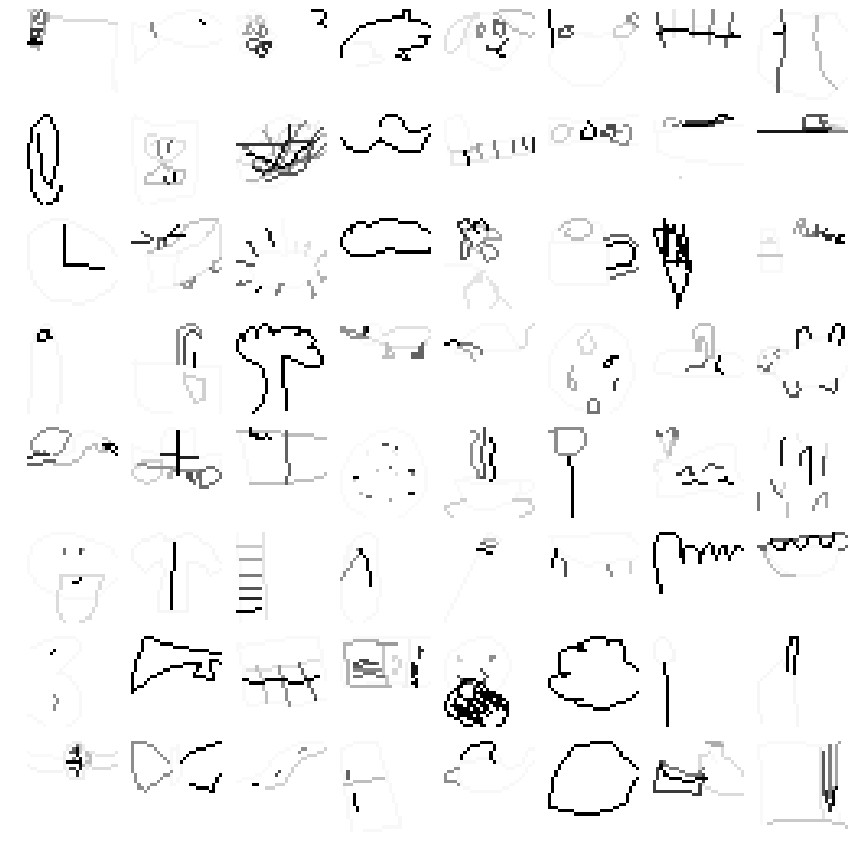

CPU times: user 4.4 s, sys: 435 ms, total: 4.84 s
Wall time: 2.82 s


In [10]:
%%time
print(f"training dataset  : {len(train_ds.x), len(train_ds.x) }") 
print(f"validation dataset: {len(valid_ds.x), len(valid_ds.x) }") 
draw_images_from_dataset(train_ds, size, line_width, linetype, nb=1000, nrows=8, compressed_drawings=True), plt.show()


In [11]:
#time to decompress 1000 images
nb, dataset = 1000, train_ds
compressed  = dataset.x[ np.random.randint(0,len(dataset.x),nb) ]
%time ims   = drawings2images(compressed, size, line_width, linetype, compressed_drawings) 

CPU times: user 78.2 ms, sys: 1.21 ms, total: 79.4 ms
Wall time: 79 ms
